# B-Cells Classification using ResNet50
In this notebook, we will carry out cell classification using ResNet50 as the underlying CNN architecture.

# Import and Costants

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from keras.utils import plot_model

# Connection to Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Utils.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will also handle the downloading and extraction of the dataset from the Google Drive folder.

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-split.zip" -d '/'

# Hardware Accelerator test
Initially, it's essential to verify if hardware acceleration is enabled, as training a CNN on a CPU might be impractical.

In [ ]:
#check hardware acceleration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Dataset loading
Next, we will create Dataset objects from the data stored in the sets directory, utilizing the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function provided by Keras.

In [ ]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


# 256 Dense Neurons
To begin, we will train a Multilayer Perceptron Network for cell classification, utilizing the features extracted by ResNet50 as input. In this process, the final layer of ResNet50, originally designed for classifying the ImageNet dataset, is removed. During this training phase, the ResNet50 layers will be frozen.

In [ ]:
base_cnn = keras.applications.resnet.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_cnn.trainable = False
base_cnn.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation_layers(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_cnn(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="ResNet50")

model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2  (None, 2048)              0  

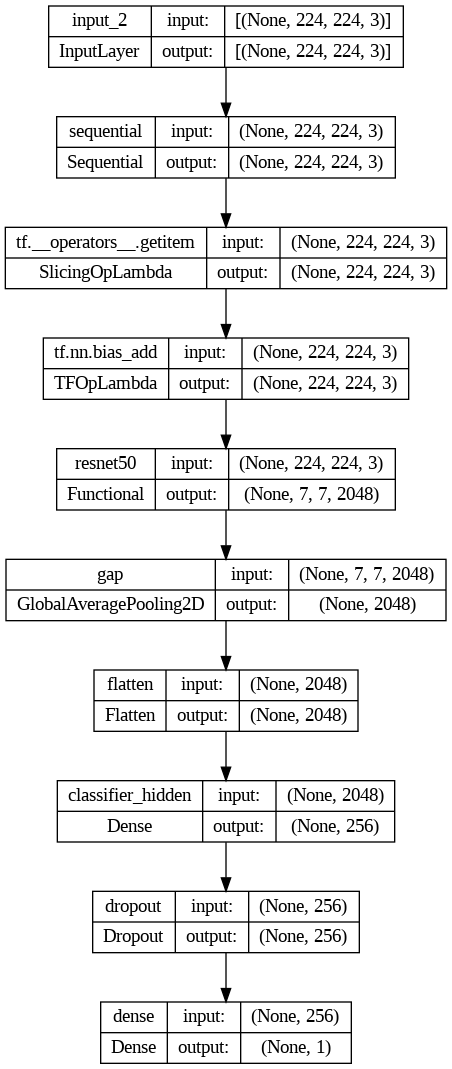

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.6942 
Epoch 1: val_loss improved from inf to 0.46307, saving model to /content/model/ResNet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 3227s 30s/step - loss: 0.6029 - accuracy: 0.6942 - val_loss: 0.4631 - val_accuracy: 0.8166
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.5111 - accuracy: 0.7563
Epoch 2: val_loss improved from 0.46307 to 0.43534, saving model to /content/model/ResNet50.h5
100/100 [==============================] - 29s 277ms/step - loss: 0.5111 - accuracy: 0.7563 - val_loss: 0.4353 - val_accuracy: 0.8260
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.7588
Epoch 3: val_loss did not improve from 0.43534
100/100 [==============================] - 29s 278ms/step - loss: 0.4974 - accuracy: 0.7588 - val_loss: 0.5451 - val_accuracy: 0.7289
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.4753 - accuracy: 0.7745
Epoch 4: val_loss improved from 0.43534 to 0.42263, saving model to /content/model/ResNet50.h5
100/100 [==============================] - 29s 284ms/step - loss: 0.4753 

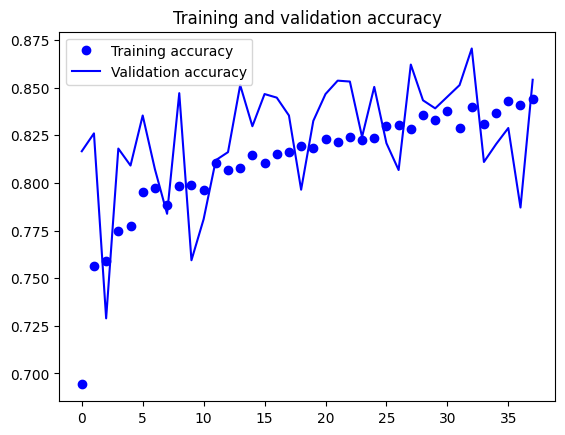

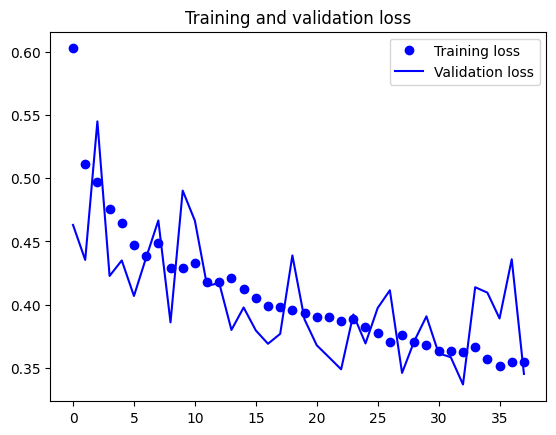

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 803s 24s/step
Classification report:
              precision    recall  f1-score   support

         all     0.8811    0.9316    0.9056      1463
         hem     0.8294    0.7254    0.7739       670

    accuracy                         0.8669      2133
   macro avg     0.8552    0.8285    0.8398      2133
weighted avg     0.8648    0.8669    0.8643      2133



34/34 [==============================] - 6s 186ms/step


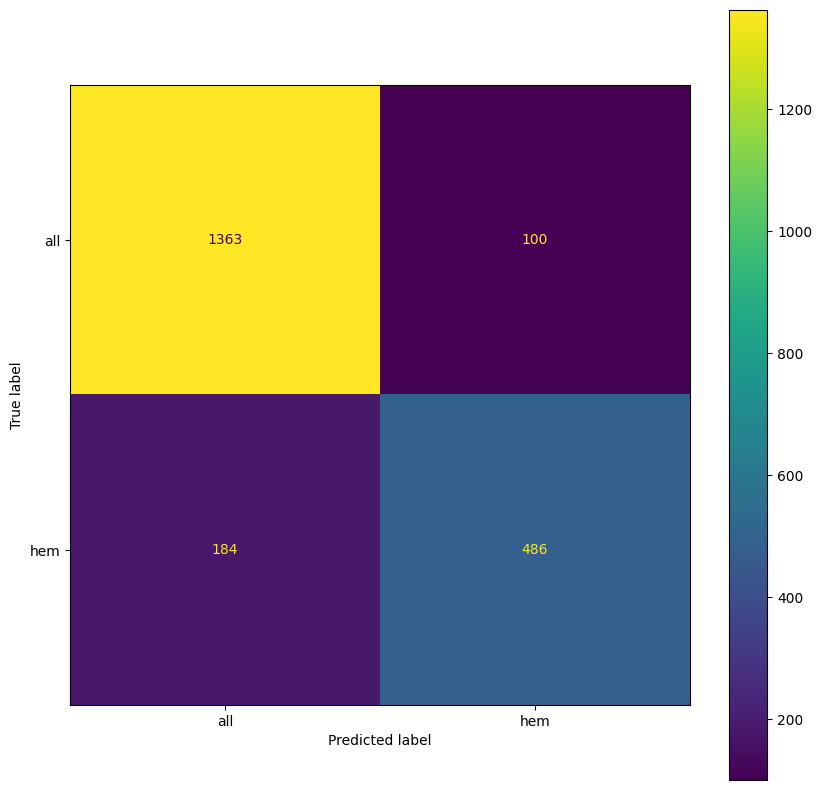

In [ ]:
plot_confusionmatrix(model, test_ds)

# 512 Dense Neurons

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation_layers(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = base_cnn(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="ResNet50_512Dense")

model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "ResNet50_512Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2  (None, 2048)        

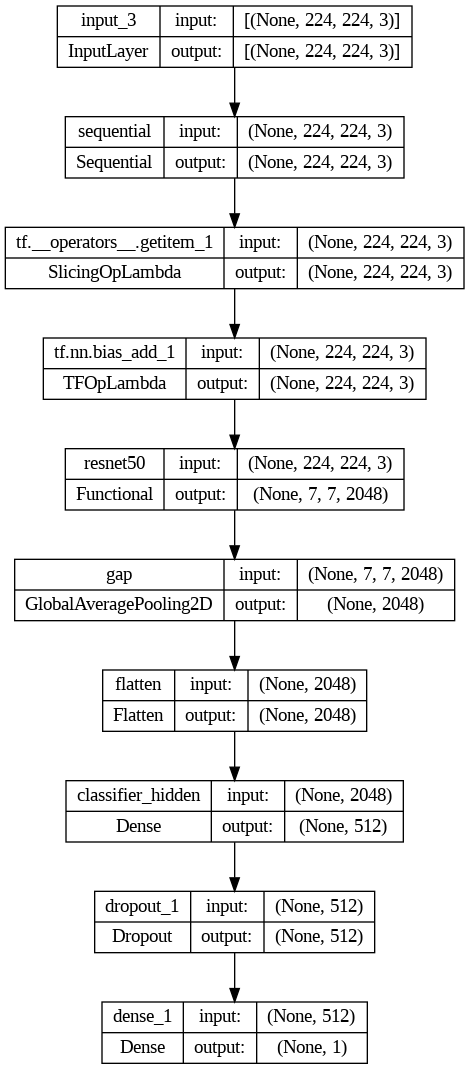

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.7089
Epoch 1: val_loss improved from inf to 0.42988, saving model to /content/model/ResNet50_512Dense.h5
100/100 [==============================] - 40s 327ms/step - loss: 0.5939 - accuracy: 0.7089 - val_loss: 0.4299 - val_accuracy: 0.8265
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.7514
Epoch 2: val_loss did not improve from 0.42988
100/100 [==============================] - 29s 283ms/step - loss: 0.5089 - accuracy: 0.7514 - val_loss: 0.4472 - val_accuracy: 0.8068
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4783 - accuracy: 0.7733
Epoch 3: val_loss did not improve from 0.42988
100/100 [==============================] - 29s 282ms/step - loss: 0.4783 - accuracy: 0.7733 - val_loss: 0.5272 - val_accuracy: 0.7359
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.4751 - accuracy: 0.7725
Epoch 4: val_loss di

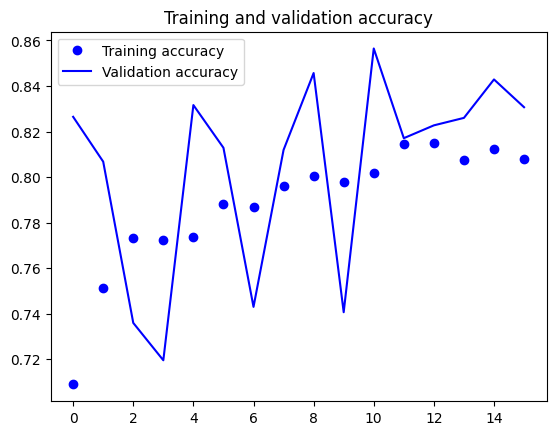

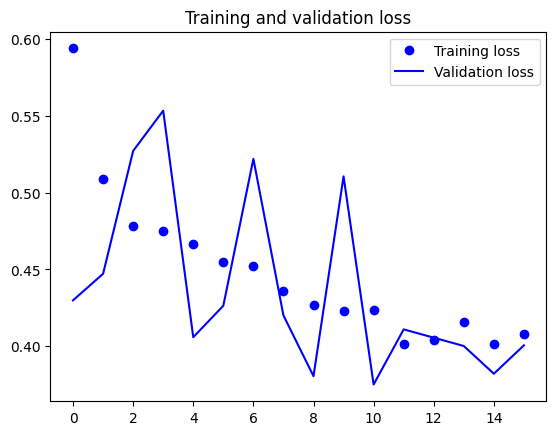

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 9s 241ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8731    0.9269    0.8992      1463
         hem     0.8155    0.7060    0.7568       670

    accuracy                         0.8575      2133
   macro avg     0.8443    0.8164    0.8280      2133
weighted avg     0.8550    0.8575    0.8545      2133



34/34 [==============================] - 6s 189ms/step


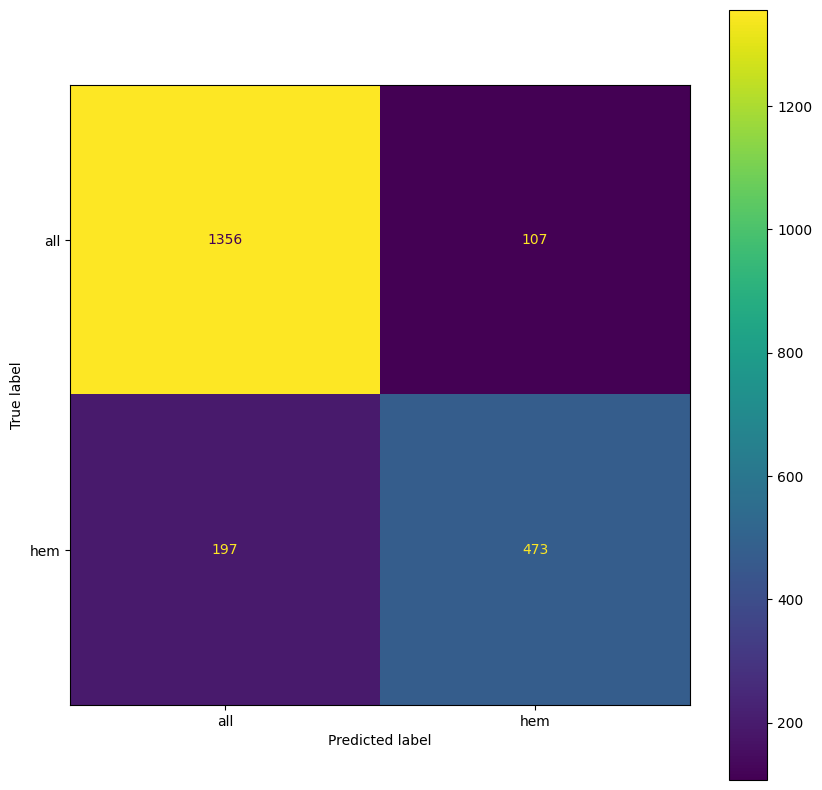

In [ ]:
plot_confusionmatrix(model, test_ds)

# Fine Tuning
Now, it's time to unfreeze the last block of ResNet50 and fine-tune its weights on our dataset.

In [ ]:
model = models.load_model(MODELS_PATH + '/ResNet50/ResNet50.h5')

In [ ]:
trainable = False
for layer in model.get_layer("resnet50").layers:
    if layer.name == 'conv5_block3_1_conv':
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 gap (GlobalAveragePooling2  (None, 2048)              0  

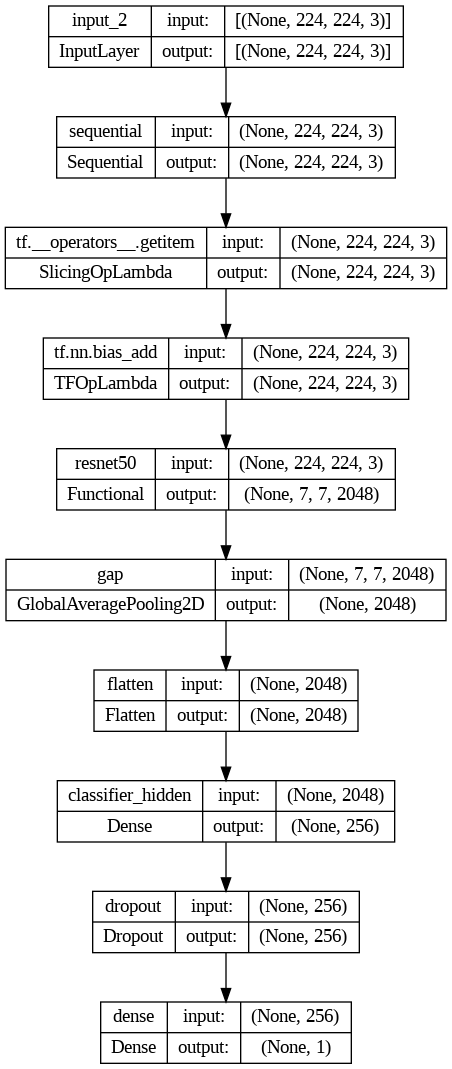

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.8382
Epoch 1: val_loss improved from inf to 0.33682, saving model to /content/model/ResNet50_Finetuned.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 33s 294ms/step - loss: 0.3564 - accuracy: 0.8382 - val_loss: 0.3368 - val_accuracy: 0.8640
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8327
Epoch 2: val_loss did not improve from 0.33682
100/100 [==============================] - 29s 280ms/step - loss: 0.3634 - accuracy: 0.8327 - val_loss: 0.3752 - val_accuracy: 0.8363
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8307
Epoch 3: val_loss did not improve from 0.33682
100/100 [==============================] - 29s 282ms/step - loss: 0.3670 - accuracy: 0.8307 - val_loss: 0.3814 - val_accuracy: 0.8288
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.8418
Epoch 4: val_loss did not improve from 0.33682
100/100 [==============================] - 30s 287ms/step - loss: 0.3529 - accuracy: 0.8418 - val_loss: 0.3584 - val_accuracy: 0.8499
Epoch 5/50
100/100 [===============

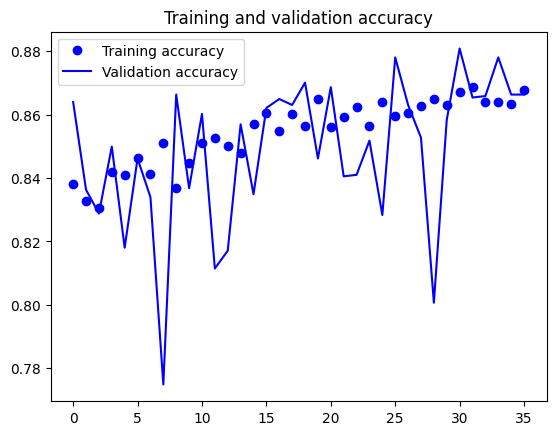

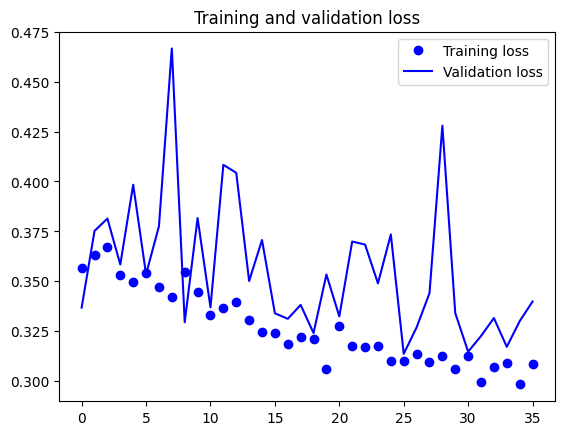

In [ ]:
model, history = run_model(model, model.name + "_Finetuned", train_ds, val_ds, 50, patience=10, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 9s 228ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8895    0.9241    0.9065      1463
         hem     0.8189    0.7493    0.7825       670

    accuracy                         0.8692      2133
   macro avg     0.8542    0.8367    0.8445      2133
weighted avg     0.8673    0.8692    0.8675      2133



34/34 [==============================] - 7s 195ms/step


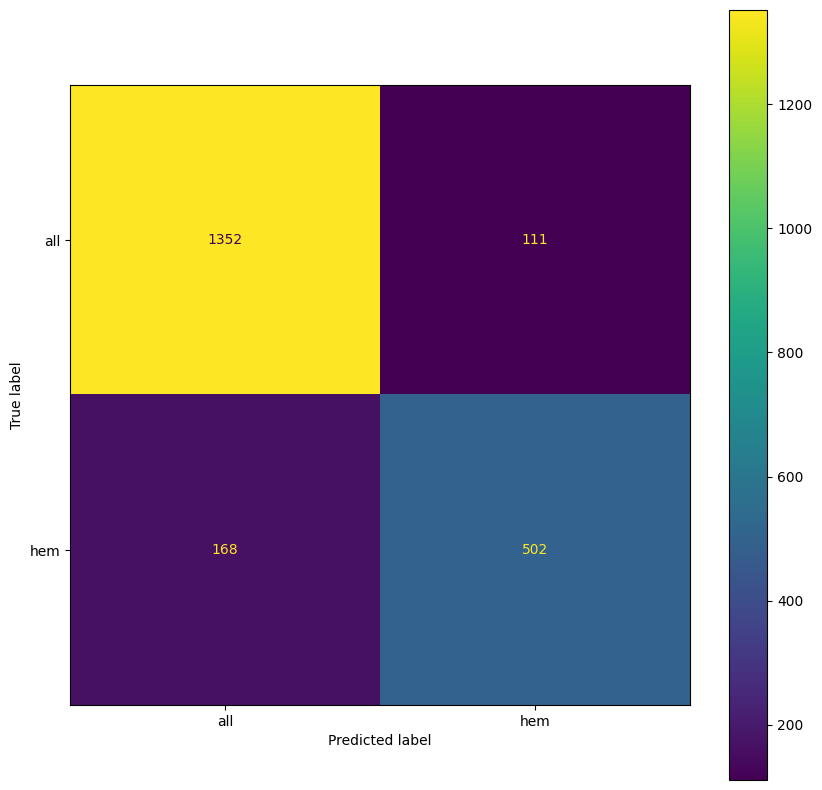

In [ ]:
plot_confusionmatrix(model, test_ds)

# Removing last block
ResNet is pre-trained on ImageNet, a dataset quite distinct from ours, which consists of MRI cell images. We can hypothesize that the convolution filters in the later layers of this CNN have learned to recognize highly specific image features, whereas the initial filters are likely geared toward extracting more general, low-level features that could be more relevant to our dataset.

We will experiment with truncating the last block of ResNet-50 before connecting the base CNN to our MLP network. Initially, we will train the MLP network on our dataset with the base frozen. Subsequently, we will fine-tune the model with the last block unfrozen.


In [ ]:
base_cnn = keras.applications.resnet50.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_cnn.trainable = False

In [ ]:
def get_layer_index(model, layer_name):
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index

In [ ]:
model = keras.Model(base_cnn.input, base_cnn.layers[get_layer_index(base_cnn, 'conv4_block6_out')].output, name='base')
model.summary()

Model: "base"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                           

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation_layers(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = model(x)
x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="ResNet50_Cutted")
model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "ResNet50_Cutted"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8589184   
                                                                 
 gap (GlobalAveragePooling2  (None, 1024)          

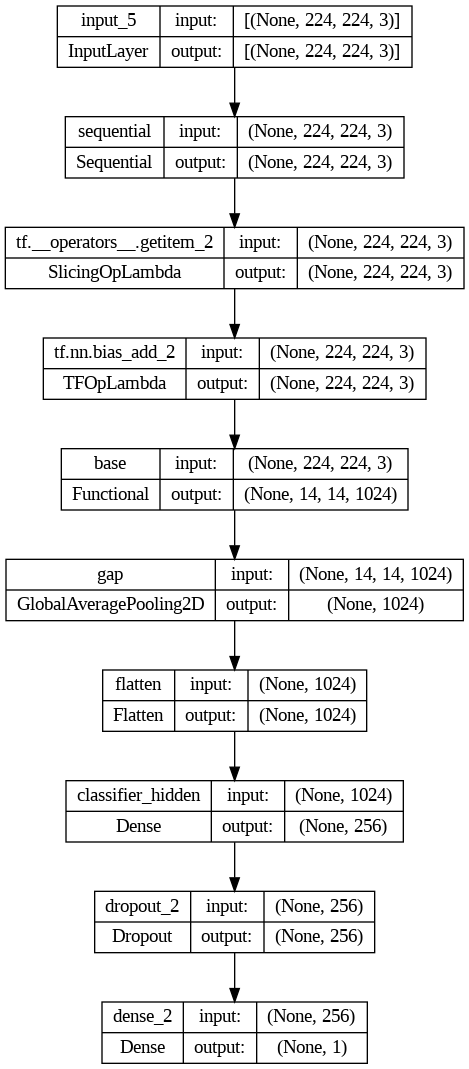

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.5951 - accuracy: 0.6853
Epoch 1: val_loss improved from inf to 0.53353, saving model to /content/model/ResNet50_Cutted.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 39s 317ms/step - loss: 0.5951 - accuracy: 0.6853 - val_loss: 0.5335 - val_accuracy: 0.7416
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.5416 - accuracy: 0.7242
Epoch 2: val_loss improved from 0.53353 to 0.50077, saving model to /content/model/ResNet50_Cutted.h5
100/100 [==============================] - 26s 256ms/step - loss: 0.5416 - accuracy: 0.7242 - val_loss: 0.5008 - val_accuracy: 0.7753
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.7434
Epoch 3: val_loss did not improve from 0.50077
100/100 [==============================] - 30s 292ms/step - loss: 0.5279 - accuracy: 0.7434 - val_loss: 0.5085 - val_accuracy: 0.7669
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5202 - accuracy: 0.7416
Epoch 4: val_loss improved from 0.50077 to 0.48421, saving model to /content/model/ResNet50_Cutted.h5
100/100 [==============================] - 31s 299ms/step -

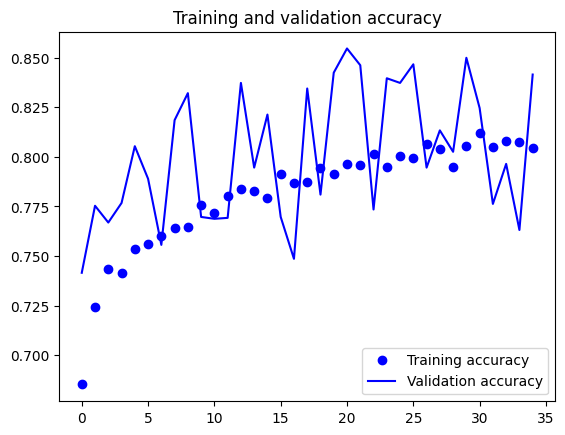

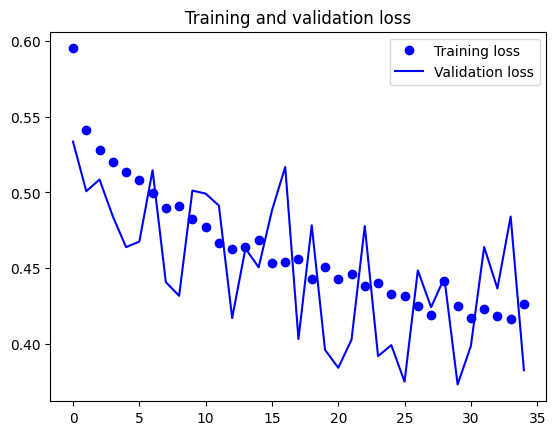

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 7s 171ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8915    0.8982    0.8948      1463
         hem     0.7739    0.7612    0.7675       670

    accuracy                         0.8551      2133
   macro avg     0.8327    0.8297    0.8311      2133
weighted avg     0.8545    0.8551    0.8548      2133



34/34 [==============================] - 6s 191ms/step


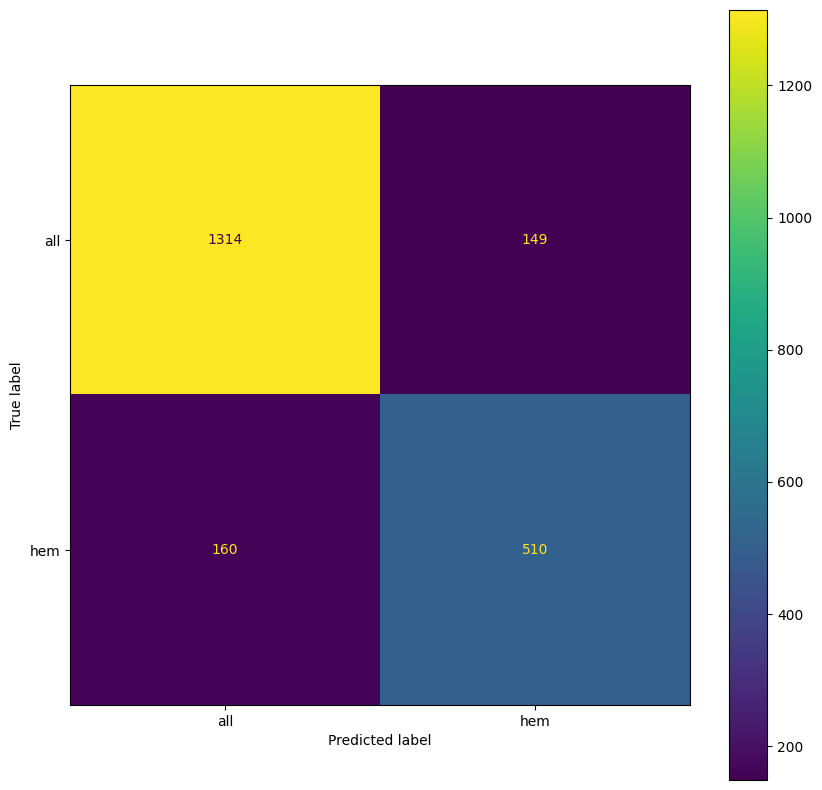

In [ ]:
plot_confusionmatrix(model, test_ds)

## Fine Tuning chopped model
Now, we will unfreeze the last block of ResNet50 and fine-tune its weights on our dataset.

In [ ]:
model.get_layer("base").summary()

Model: "base"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                           

In [ ]:
trainable = False
for layer in model.get_layer("base").layers:
    if layer.name == 'conv4_block6_1_conv':
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable


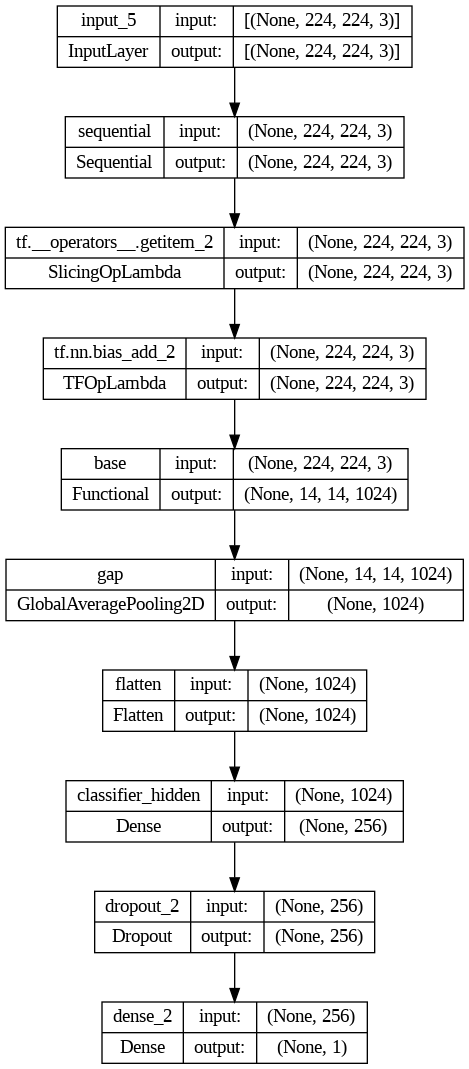

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.4200 - accuracy: 0.8077
Epoch 1: val_loss improved from inf to 0.41489, saving model to /content/model/ResNet50_Cutted_Finetuned.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 33s 294ms/step - loss: 0.4200 - accuracy: 0.8077 - val_loss: 0.4149 - val_accuracy: 0.8265
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.8030
Epoch 2: val_loss improved from 0.41489 to 0.40376, saving model to /content/model/ResNet50_Cutted_Finetuned.h5
100/100 [==============================] - 27s 263ms/step - loss: 0.4226 - accuracy: 0.8030 - val_loss: 0.4038 - val_accuracy: 0.8288
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8139
Epoch 3: val_loss did not improve from 0.40376
100/100 [==============================] - 26s 257ms/step - loss: 0.4121 - accuracy: 0.8139 - val_loss: 0.4349 - val_accuracy: 0.8096
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.4118 - accuracy: 0.8111
Epoch 4: val_loss improved from 0.40376 to 0.38351, saving model to /content/model/ResNet50_Cutted_Finetuned.h5
100/100 [==============================

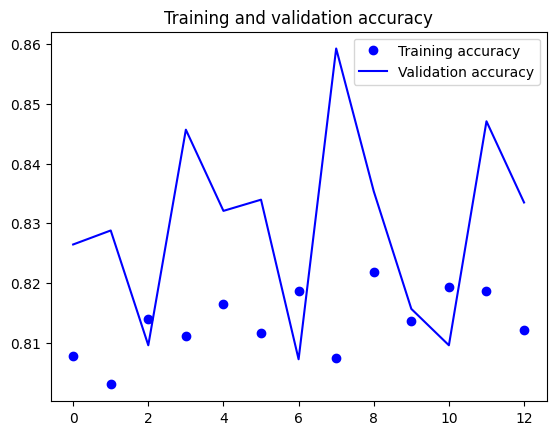

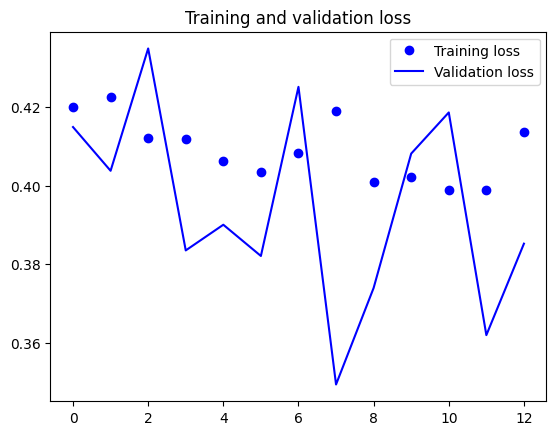

In [ ]:
model, history = run_model(model, model.name + "_Finetuned", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 7s 185ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8971    0.9057    0.9014      1463
         hem     0.7896    0.7731    0.7813       670

    accuracy                         0.8640      2133
   macro avg     0.8434    0.8394    0.8413      2133
weighted avg     0.8633    0.8640    0.8636      2133



34/34 [==============================] - 7s 196ms/step


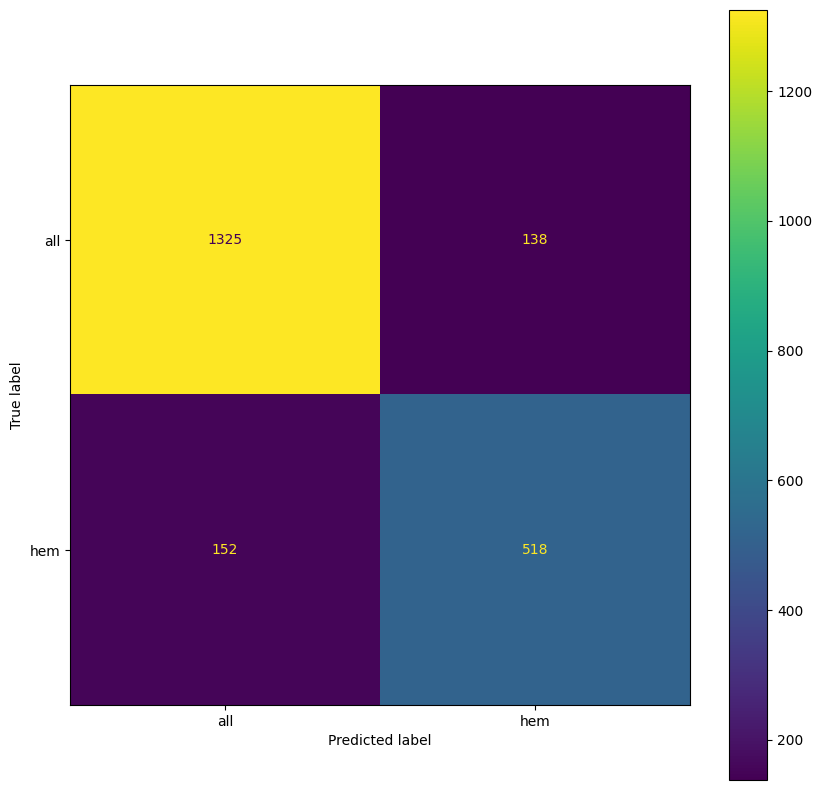

In [ ]:
plot_confusionmatrix(model, test_ds)